# Geometrical Methods in Machine Learning

## Seminar 4: Nonlinear Dimensionality Reduction

In [ ]:
!pip install --upgrade sklearn
!pip install --upgrade grakel
!pip install --upgrade POT

In [2]:
from __future__ import print_function

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import offsetbox

import numpy as np

from sklearn.datasets import load_digits, fetch_olivetti_faces, make_moons, make_circles, make_swiss_roll, fetch_openml
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel, sigmoid_kernel, cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.manifold import MDS, Isomap, LocallyLinearEmbedding, SpectralEmbedding

from grakel import GraphKernel
from grakel.kernels import VertexHistogram, ShortestPath, WeisfeilerLehman
from grakel.datasets import fetch_dataset

import ot

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 1. Kernel PCA

In [3]:
# load data
X, y = make_moons(n_samples=500, noise=0.01, random_state=42)
X_std = StandardScaler().fit_transform(X)

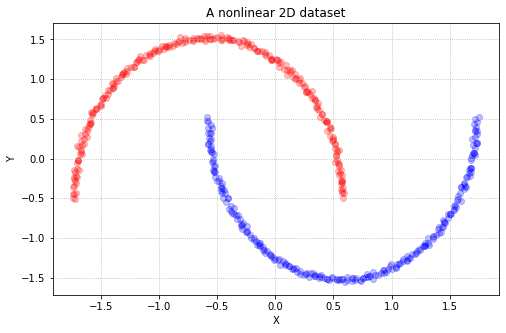

In [4]:
plt.figure(figsize=(8,5))
plt.scatter(X_std[y==0, 0], X_std[y==0, 1], color='red', alpha=0.25)
plt.scatter(X_std[y==1, 0], X_std[y==1, 1], color='blue', alpha=0.25)
plt.title('A nonlinear 2D dataset')
plt.ylabel('Y')
plt.xlabel('X')
plt.grid(linestyle="dotted")
plt.show()

In [5]:
# apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pca_1d = PCA(n_components=1)
X_pca_1d = pca_1d.fit_transform(X)

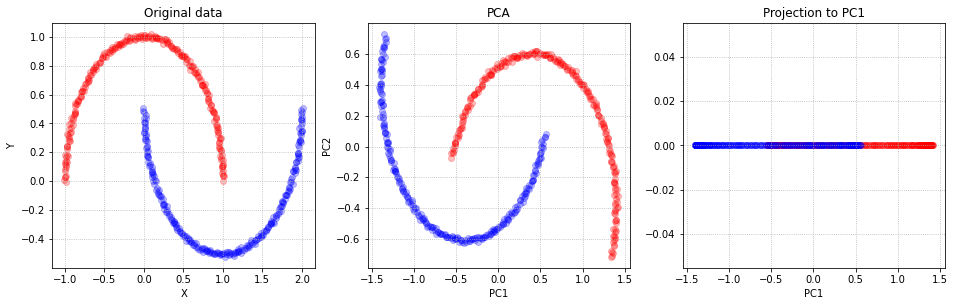

In [6]:
plt.figure(figsize=(16,4.5))

plt.subplot(131)
plt.title('Original data')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(linestyle="dotted")
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.25)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.25)

plt.subplot(132)
plt.title('PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(linestyle="dotted")
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], color='red', alpha=0.25)
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], color='blue', alpha=0.25)

plt.subplot(133)
plt.title('Projection to PC1')
plt.xlabel('PC1')
plt.grid(linestyle="dotted")
plt.scatter(X_pca_1d[y==0, 0], np.zeros((int(X_pca.shape[0]/2),1)), color='red', alpha=0.25)
plt.scatter(X_pca_1d[y==1, 0], np.zeros((int(X_pca.shape[0]/2),1)), color='blue', alpha=0.25)

plt.show()

## 1.1 Kernels

Kernel is any symmetric positive-definite function of the form:

$$K(\mathbf{x}, \mathbf{x}') = \langle \phi(\mathbf{x}), \phi(\mathbf{x}') \rangle$$

where $\phi$ is a function that projects vectors $\mathbf{x}$ and $\mathbf{x}'$ into a new vector space. The kernel function can be seen as a function that computes the inner-product between two vectors in some, potentially infinite-dimensinal space.

### 1.1.1 Linear kernel

A _linear kernel_ is given by $\mathbf{x}^T\mathbf{x}$, thus the inner product in the original vector space. Consider a $n \times m$ dataset $\mathbf{X} = \{ \mathbf{x}_1, \dots, \mathbf{x}_n\}$ with $n$ observations and $m$ features, then _Gram matrix_ $\mathbf{G} = \mathbf{X} \mathbf{X}^T$ is a matrix of inner-products, in this notation covariance matrix $\mathbf{S}$ is given by $\mathbf{X}^T\mathbf{X}$.

#### Exercise

Compute the matrix of pairwise linear kernels for a moons dataset $\mathbf{X}$, check that it is Gram matrix. You can use `linear_kernel` from `sklearn.metrics.pairwise`.

In [13]:
K = linear_kernel(X)
G = X @ X.T

array([[ 0.91820749,  0.13596996,  1.06825662, ...,  0.74939004,
         1.50494245, -0.24466156],
       [ 0.13596996,  1.03037764,  0.22496288, ...,  0.0660651 ,
         0.85908216,  0.9534586 ],
       [ 1.06825662,  0.22496288,  1.24723955, ...,  0.8688837 ,
         1.79292533, -0.21922821],
       ...,
       [ 0.74939004,  0.0660651 ,  0.8688837 , ...,  0.61360671,
         1.19996981, -0.24367158],
       [ 1.50494245,  0.85908216,  1.79292533, ...,  1.19996981,
         2.86728235,  0.22228226],
       [-0.24466156,  0.9534586 , -0.21922821, ..., -0.24367158,
         0.22228226,  1.03474383]])

Kernel PCA with linear kernel obviously is equivalent to PCA.

In [14]:
# apply Kernel PCA with linear kernel
kpca = KernelPCA(n_components=2)
X_kpca = kpca.fit_transform(X)

kpca_1d = KernelPCA(n_components=1)
X_kpca_1d = kpca_1d.fit_transform(X)

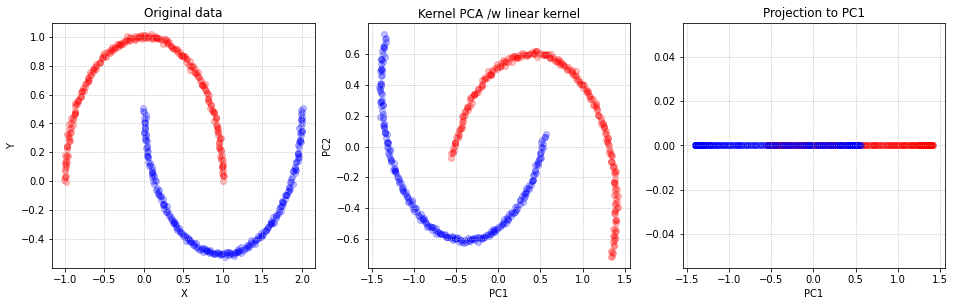

In [15]:
plt.figure(figsize=(16,4.5))

plt.subplot(131)
plt.title('Original data')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(linestyle="dotted")
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.25)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.25)

plt.subplot(132)
plt.title('Kernel PCA /w linear kernel')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(linestyle="dotted")
plt.scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', alpha=0.25)
plt.scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', alpha=0.25)

plt.subplot(133)
plt.title('Projection to PC1')
plt.xlabel('PC1')
plt.grid(linestyle="dotted")
plt.scatter(X_pca_1d[y==0, 0], np.zeros((int(X_pca.shape[0]/2),1)), color='red', alpha=0.25)
plt.scatter(X_pca_1d[y==1, 0], np.zeros((int(X_pca.shape[0]/2),1)), color='blue', alpha=0.25)

plt.show()

### 1.1.2 Gaussian kernel

A radial basis function (RBF) is a real-valued function whose value depends only on the distance $d_X$ from some other point $x'$, so that $\phi_{\mathbf{x}'} (\mathbf {x} )= \phi (\|\mathbf {x} -\mathbf {x'} \|)$.

Many distances $d_X$ induce radial basis kernels which given by:

$$K(\mathbf{x}, \mathbf{x}') = \exp \left(- \gamma \| \mathbf{x} -\mathbf{x}' \|^2\right)$$

 If $\gamma = \frac{1}{2 \sigma^2}$ it is known as the Gaussian kernel:

$$K(\mathbf{x}, \mathbf{x}') = \exp \left(- \frac{\| \mathbf{x} -\mathbf{x}' \|^2 }{2 \sigma^2}\right)$$

#### Exercise

Compute the matrix of pairwise RBF kernels for a dataset $\mathbf{X}$. Implement Gaussian kernel, check whether it values are equals scikit-learn solution. Check kernel values for different $\gamma$ and $\sigma$. You can use `rbf_kernel` from `sklearn.metrics.pairwise`.

In [45]:
# compute K for X, matrix of paiwise RBF kernels for dataset X
gamma1 = 1 / X.shape[1]
gamma2 = 0.01

K1 = rbf_kernel(X, gamma=gamma1)
K2 = rbf_kernel(X, gamma=gamma2)
K1, K2

(array([[1.        , 0.43243528, 0.98563725, ..., 0.9836186 , 0.67854636,
         0.29489462],
        [0.43243528, 1.        , 0.40097921, ..., 0.46957508, 0.33630128,
         0.92394555],
        [0.98563725, 0.40097921, 1.        , ..., 0.94031587, 0.76771584,
         0.25660434],
        ...,
        [0.9836186 , 0.46957508, 0.94031587, ..., 1.        , 0.58247168,
         0.34374786],
        [0.67854636, 0.33630128, 0.76771584, ..., 0.58247168, 1.        ,
         0.17750956],
        [0.29489462, 0.92394555, 0.25660434, ..., 0.34374786, 0.17750956,
         1.        ]]),
 array([[1.00000000e+00, 2.28671062e-04, 8.65308684e-01, ...,
         8.47749092e-01, 2.06916567e-02, 4.97357253e-06],
        [2.28671062e-04, 1.00000000e+00, 1.07452990e-04, ...,
         5.21255252e-04, 1.85048368e-05, 4.53381487e-01],
        [8.65308684e-01, 1.07452990e-04, 1.00000000e+00, ...,
         5.40427764e-01, 7.11221695e-02, 1.23777019e-06],
        ...,
        [8.47749092e-01, 5.21255252e

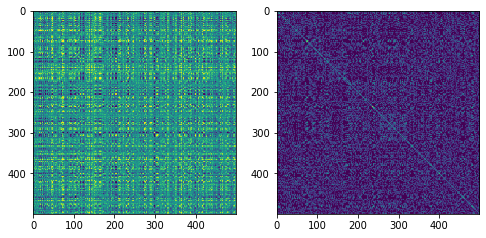

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ax[0].imshow((K1 > 0.5).astype(float))
ax[1].imshow((K2 > 0.5).astype(float))
plt.show()

In [52]:
# implement Gaussian kernel
def gaussian_kernel(x, x_prime, sigma=1):
    return np.exp( - (np.linalg.norm(x - x_prime) ** 2) / (2 * sigma ** 2))

In [54]:
gaussian_kernel(X[0], X[0])

1.0

#### Exercise

Apply Kernel PCA with Gaussian kernel with different values of $\gamma$ to Moons dataset.

In [55]:
# apply KernelPCA with Gaussian kernel
gamma = 20

kpca = KernelPCA(n_components=2, kernel="rbf", gamma=gamma)
X_kpca = kpca.fit_transform(X)

kpca_1d = KernelPCA(n_components=1, kernel="rbf", gamma=gamma)
X_kpca_1d = kpca_1d.fit_transform(X)

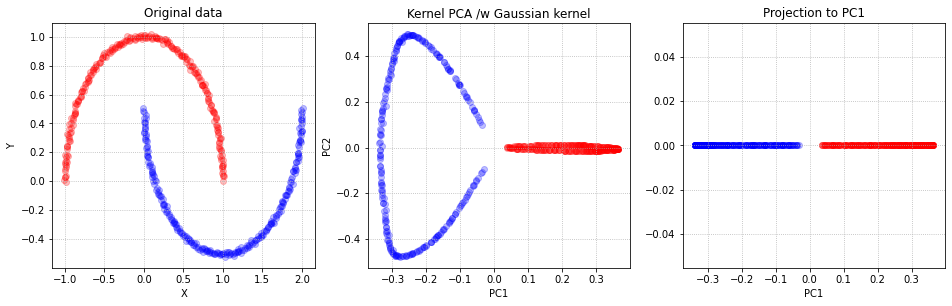

In [56]:
plt.figure(figsize=(16,4.5))

plt.subplot(131)
plt.title('Original data')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(linestyle="dotted")
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.25)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.25)

plt.subplot(132)
plt.title('Kernel PCA /w Gaussian kernel')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(linestyle="dotted")
plt.scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', alpha=0.25)
plt.scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', alpha=0.25)

plt.subplot(133)
plt.title('Projection to PC1')
plt.xlabel('PC1')
plt.grid(linestyle="dotted")
plt.scatter(X_kpca_1d[y==0, 0], np.zeros((int(X_kpca.shape[0]/2),1)), color='red', alpha=0.25)
plt.scatter(X_kpca_1d[y==1, 0], np.zeros((int(X_kpca.shape[0]/2),1)), color='blue', alpha=0.25)

plt.show()

### 1.1.3 Polynomial kernel

The polynomial kernel is defined as:

$$K(\mathbf{x}, \mathbf{x'}) = (\gamma \mathbf{x}^\top \mathbf{x}' + c)^d$$

where $\mathbf{x}, \mathbf{x'}$ are the input vectors, $\gamma$, $c$ are scalars and $d$ is the kernel degree.

#### Exercise

Apply KernelPCA with polynomial kernel to Moons dataset.

Check how standartization affects embedding with polynomial kernel.

In [57]:
# standartize the data
X_std = StandardScaler().fit_transform(X)

In [70]:
# apply KernelPCA with Gaussian kernel
degree = 8

kpca = KernelPCA(n_components=2, kernel="poly", degree=degree)
X_kpca = kpca.fit_transform(X_std)

kpca_1d = KernelPCA(n_components=1, kernel="poly", degree=degree)
X_kpca_1d = kpca_1d.fit_transform(X_std)

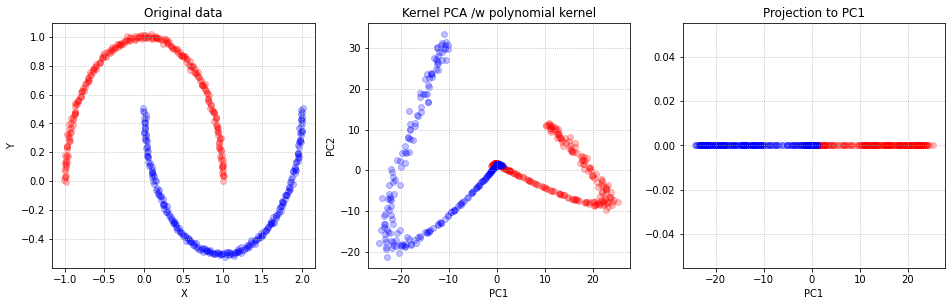

In [71]:
plt.figure(figsize=(16,4.5))

plt.subplot(131)
plt.title('Original data')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(linestyle="dotted")
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.25)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.25)

plt.subplot(132)
plt.title('Kernel PCA /w polynomial kernel')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(linestyle="dotted")
plt.scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', alpha=0.25)
plt.scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', alpha=0.25)

plt.subplot(133)
plt.title('Projection to PC1')
plt.xlabel('PC1')
plt.grid(linestyle="dotted")
plt.scatter(X_kpca_1d[y==0, 0], np.zeros((int(X_kpca.shape[0]/2),1)), color='red', alpha=0.25)
plt.scatter(X_kpca_1d[y==1, 0], np.zeros((int(X_kpca.shape[0]/2),1)), color='blue', alpha=0.25)

plt.show()

### 1.1.4. Cosine similarity

Cosine similarity is the normalized dot product between vectors $\mathbf{x}, \mathbf{x}'$ which is the cosine of the angle between the points denoted by the vectors:

$$K(\mathbf{x}, \mathbf{x}') = \frac{\mathbf{x} \mathbf{x}'^\top}{\|\mathbf{x}\| \|\mathbf{x}'\|}$$

#### Exercise

Apply Kernel PCA with cosine similarity `cosine_similarity` as precomputed kernel to Moons dataset.

Check how standartization affects embedding with cosine similarity kernel.

In [72]:
# standartize the data
X_std = StandardScaler().fit_transform(X)

In [77]:
# compute K, matrix of paiwise cosine similarities of dataset X
K = cosine_similarity(X_std)
K

array([[ 1.        , -0.9289103 ,  0.99394457, ...,  0.99240743,
         0.77014406, -0.99725961],
       [-0.9289103 ,  1.        , -0.8825953 , ..., -0.9674027 ,
        -0.47918842,  0.95376045],
       [ 0.99394457, -0.8825953 ,  1.        , ...,  0.9728831 ,
         0.83557132, -0.98309149],
       ...,
       [ 0.99240743, -0.9674027 ,  0.9728831 , ...,  1.        ,
         0.6858426 , -0.99878713],
       [ 0.77014406, -0.47918842,  0.83557132, ...,  0.6858426 ,
         1.        , -0.72084294],
       [-0.99725961,  0.95376045, -0.98309149, ..., -0.99878713,
        -0.72084294,  1.        ]])

In [78]:
# apply KernelPCA with cosine similarity as precomputed kernel
kpca = KernelPCA(n_components=2, kernel="precomputed")
X_kpca = kpca.fit_transform(K)

kpca_1d = KernelPCA(n_components=1, kernel="precomputed")
X_kpca_1d = kpca_1d.fit_transform(K)

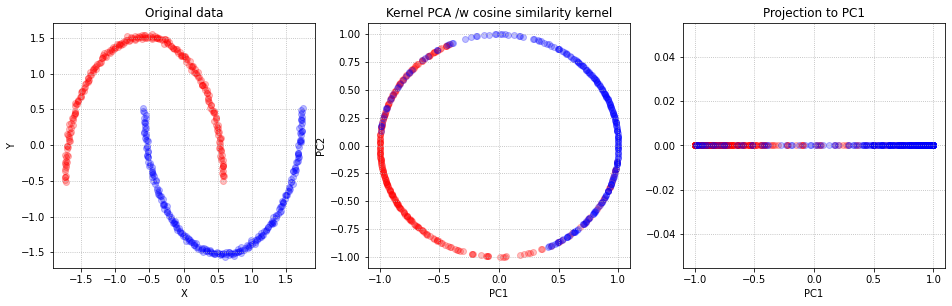

In [79]:
plt.figure(figsize=(16,4.5))

plt.subplot(131)
plt.title('Original data')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(linestyle="dotted")
plt.scatter(X_std[y==0, 0], X_std[y==0, 1], color='red', alpha=0.25)
plt.scatter(X_std[y==1, 0], X_std[y==1, 1], color='blue', alpha=0.25)
#plt.scatter(X[y==0, 0], X[y==0, 1], color='green', alpha=0.25)
#plt.scatter(X[y==1, 0], X[y==1, 1], color='orange', alpha=0.25)

plt.subplot(132)
plt.title('Kernel PCA /w cosine similarity kernel')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(linestyle="dotted")
plt.scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', alpha=0.25)
plt.scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', alpha=0.25)

plt.subplot(133)
plt.title('Projection to PC1')
plt.xlabel('PC1')
plt.grid(linestyle="dotted")
plt.scatter(X_kpca_1d[y==0, 0], np.zeros((int(X_kpca.shape[0]/2),1)), color='red', alpha=0.25)
plt.scatter(X_kpca_1d[y==1, 0], np.zeros((int(X_kpca.shape[0]/2),1)), color='blue', alpha=0.25)

plt.show()

### 1.2 Graph kernels

In [99]:
# load graph dataset
mutag = fetch_dataset("PROTEINS", verbose=False)
X_mutag, y_mutag = mutag.data, mutag.target
np.unique(y_mutag)

array([1, 2])

In [95]:
# intitalize Weisfeiler-Lehman kernel with Vertex histogram as the base kernel
wl_kernel = WeisfeilerLehman(n_iter=5, normalize=True, base_graph_kernel=VertexHistogram)

In [96]:
# compute Weisfeiler-Lehman kernel
K = wl_kernel.fit_transform(X_mutag)
K

array([[1.        , 0.75577503, 0.55198954, ..., 0.36015957, 0.38639622,
        0.11566778],
       [0.75577503, 1.        , 0.52524704, ..., 0.3422663 , 0.32839276,
        0.10788879],
       [0.55198954, 0.52524704, 1.        , ..., 0.09105111, 0.18455166,
        0.12806928],
       ...,
       [0.36015957, 0.3422663 , 0.09105111, ..., 1.        , 0.2031498 ,
        0.3668976 ],
       [0.38639622, 0.32839276, 0.18455166, ..., 0.2031498 , 1.        ,
        0.04151827],
       [0.11566778, 0.10788879, 0.12806928, ..., 0.3668976 , 0.04151827,
        1.        ]])

#### Exercise

Compute the Kernel PCA embedding of MUTAG graph dataset, given by Weisfeiler-Lehman kernel.

In [97]:
# apply Kernel PCA with Weisfeiler-Lehman kernel as precomputed kernel
kpca = KernelPCA(n_components=3, kernel="precomputed")
X_kpca_mutag = kpca.fit_transform(K)

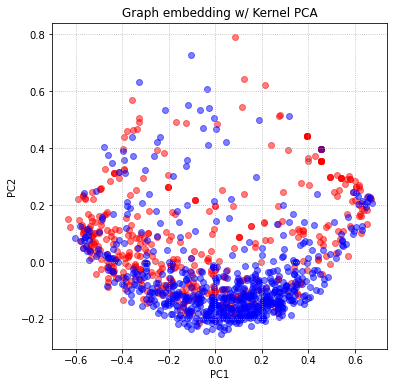

In [100]:
plt.figure(figsize=(6,6))

plt.title('Graph embedding w/ Kernel PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(linestyle="dotted")
plt.scatter(X_kpca_mutag[y_mutag==2, 0], X_kpca_mutag[y_mutag==2, 1], color='red', alpha=0.5)
plt.scatter(X_kpca_mutag[y_mutag==1, 0], X_kpca_mutag[y_mutag==1, 1], color='blue', alpha=0.5)

plt.show()

### 1.3. Swiss roll

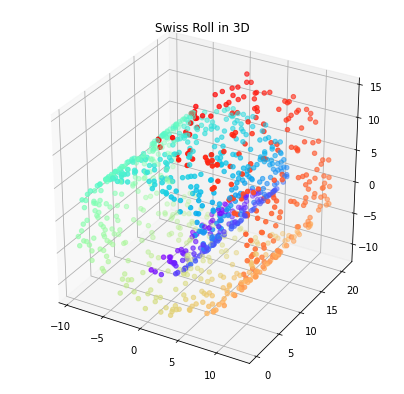

In [101]:
X, color = make_swiss_roll(n_samples=1000, random_state=123)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.rainbow)
plt.title('Swiss Roll in 3D')
plt.show()

#### Exercise

Apply Kernel PCA with different kernels and kernel parameters to Swiss roll dataset. Compare results.

In [102]:
# standartize the data
X_std = StandardScaler().fit_transform(X)

In [120]:
kpca = KernelPCA(n_components=2, kernel="rbf", gamma=2)
X_kpca = kpca.fit_transform(X_std)

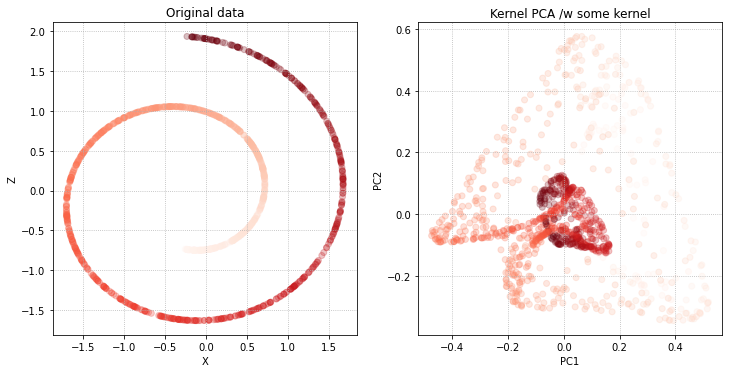

In [121]:
plt.figure(figsize=(12,5.75))

plt.subplot(121)
plt.title('Original data')
plt.xlabel('X')
plt.ylabel('Z')
plt.grid(linestyle="dotted")
plt.scatter(X_std[:, 0], X_std[:, 2], c=color, cmap="Reds", alpha=0.25)

plt.subplot(122)
plt.title('Kernel PCA /w some kernel')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(linestyle="dotted")
plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=color, cmap="Reds", alpha=0.25)

plt.show()

**NB:** Kernel PCA with standard kernels fails to unroll swiss roll dataset.

## 2. Manifold Learning Methods

### 2.1 PCA

In [122]:
model = PCA(n_components=2)
X_pca = model.fit_transform(X)

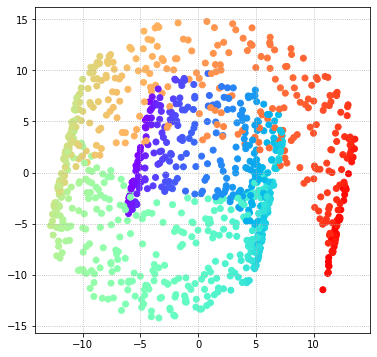

In [123]:
plt.figure(figsize=(6,6))
plt.grid(linestyle="dotted")
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=color, cmap=plt.cm.rainbow)

### 2.2 Kernel PCA

In [124]:
model = KernelPCA(n_components=2, kernel="poly", degree=3)
X_kpca = model.fit_transform(X)

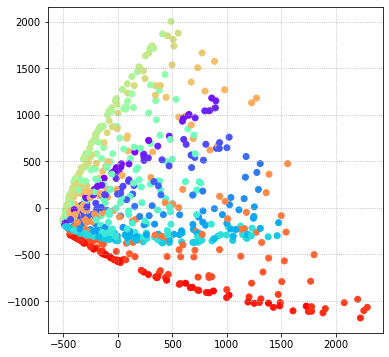

In [125]:
plt.figure(figsize=(6,6))
plt.grid(linestyle="dotted")
plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=color, cmap=plt.cm.rainbow)

### 2.3 MDS

#### Intuition

Embedding should preserve distances between points.

$$J_{MDS}(z_1, \dots, z_n) = \sum_{ij}^n ((x_i, x_j) - (z_i, z_j))^2$$

#### Algorithm

Given a dataset $X = \{x_1, \dots, x_n \} \in \mathbb{R}^{D \times n}$,

1. Compute Gram matrix of $G \in \mathbb{R}^{n \times n}$, s.t. $g_{ij} = (x_i, x_j) = X^TX$
2. Find $d$ eigenvectors $\{ v_1, \dots, v_d \} \in \mathbb{R}^{n \times d}$ of $G$, corresponding to $d$ largest eigenvalues: $\Lambda = diag(\lambda_1, \dots, \lambda_d) \in \mathbb{R}^{d \times d}$.
3. Compute the embedding $\{z_1, \dots, z_n \} = \Lambda^{1/2} \{ v_1, \dots, v_d \}^T$

### 2.4 Isomap

#### Intuition

Manifold is globally isometric to a convex subset of Euclidean space.

#### Algorithm

Given a dataset $X = \{x_1, \dots, x_n \} \in \mathbb{R}^{D \times n}$,

1. Estimate the neighborhood $\mathcal{N}_i$ of each point, eigher within $\varepsilon$-ball or take $k$ nearest neighbors.
2. Build a graph on points, with adjancency matrix $A$, s.t. $a_{ij} = 1$ if the points are neighbors and $0$ otherwise.
3. Estimate pairwise geodesic distances between any two points, by shortest paths between nodes of the graph.
4. Perform MDS on pairwise distance matrix.

In [126]:
model = Isomap(n_components=2)
X_isomap = model.fit_transform(X)

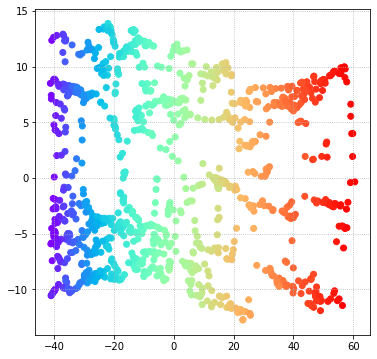

In [127]:
plt.figure(figsize=(6,6))
plt.grid(linestyle="dotted")
plt.scatter(X_isomap[:, 0], X_isomap[:, 1], c=color, cmap=plt.cm.rainbow)

### 2.5 Locally Linear Embedding

#### Intuition

Manifold is locally linear. The same weights that reconstruct the datapoints in $D$ dimensions should reconstruct it in the manifold in $d$ dimensions.

#### Algorithm

Given a dataset $X = \{x_1, \dots, x_n \} \in \mathbb{R}^D$,

- Estimate the neighborhood $\mathcal{N}_i$ of each point, eigher within $\varepsilon$-ball or take $k$ nearest neighbors.
- 

$$W = \arg \min_W \sum_i^n \| x_i - \sum_j^n W_{ij} x_j \|^2, \\
s.t. \sum_j^n W_{ij} = 1, \forall i, \\
W_{ij} = 0, x_j \notin \mathcal{N}_i$$

- Given the weights W, find the embedded points:

$$\{z_1, \dots, z_n\} = \arg \min_{\{z_1, \dots, z_n\}} \sum_i^n \| z_i - \sum_i^n W_{ij} z_j \|^2 \\
s.t. \sum_i^n z_i = 0\\
cov(Z) = \mathbb{I}$$

The same weights that reconstruct the datapoints in $D$ dimensions should reconstruct it in the manifold in $d$ dimensions.

In [140]:
model = LocallyLinearEmbedding(n_components=2, n_neighbors=15)
X_lle = model.fit_transform(X)

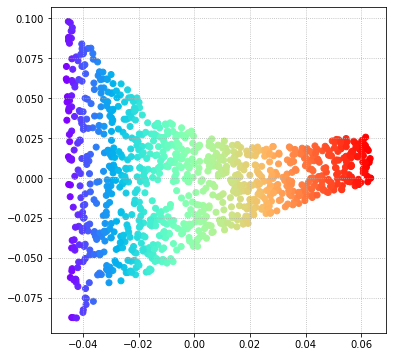

In [141]:
plt.figure(figsize=(6,6))
plt.grid(linestyle="dotted")
plt.scatter(X_lle[:, 0], X_lle[:, 1], c=color, cmap=plt.cm.rainbow)

### 1.6 Laplacian Eigenmaps

#### Intuition

Manifold can be reconstructed with computing Laplacian of the graph, which is empirical version of Laplace-Beltrami operator of smooth manifold.

#### Algorithm

Given a dataset $X = \{x_1, \dots, x_n \} \in \mathbb{R}^{D \times n}$,

1. Estimate the neighborhood $\mathcal{N}_i$ of each point, eigher within $\varepsilon$-ball or take $k$ nearest neighbors.
2. Build adjancency graph, with adjacency matrix $A$ s.t.

$$a_{ij} = \exp(-\lambda \| x_i - x_j \|^2), \textrm{if}~x_j \in \mathcal{N}_i \\
a_{ij} = 0,~\textrm{otherwise}$$

3. Compute graph Laplacian $L(A) = D - A \in \mathbb{R}^{n \times n}$, where $D$ s.t. $d_{ii} = \sum_i^n A_{ij}$ and solve eigenvalue problem: 

$$Lv = \lambda Dv,\\
v \in \mathbb{R}^n$$

Given $d+1$ eigenvectors, corresponding to _smallest_ eigenvalues, compute the emdedding:

$$\{z_1, \dots, z_n \} = \{f_1(i), \dots, f_d(i)\}^T \in \mathbb{R}^d$$

In [146]:
model = SpectralEmbedding(n_components=2, n_neighbors=30)
X_le = model.fit_transform(X)

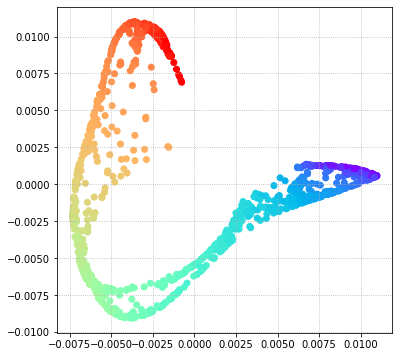

In [147]:
plt.figure(figsize=(6,6))
plt.grid(linestyle="dotted")
plt.scatter(X_le[:, 0], X_le[:, 1], c=color, cmap=plt.cm.rainbow)

### 2.7 Local Tangent Space Alignment

#### Intuition

Local linearity assumption. Manifold can be approximated using tangent spaces to each point.

#### Algorithm

Given a dataset $X = \{x_1, \dots, x_n \} \in \mathbb{R}^{D \times n}$,

1. Estimate the neighborhood $\mathcal{N}_i$ of each point, eigher within $\varepsilon$-ball or take $k$ nearest neighbors.
2. Build a graph on points, with adjancency matrix $A$, s.t. $a_{ij} = 1$ if the points are neighbors and $0$ otherwise.
3. Estimate tangent spaces to each point using Local PCA, align tangent spaces.
4. Compute the embedding.

In [148]:
model = LocallyLinearEmbedding(n_components=2, n_neighbors=15, method="ltsa")
X_ltsa = model.fit_transform(X)

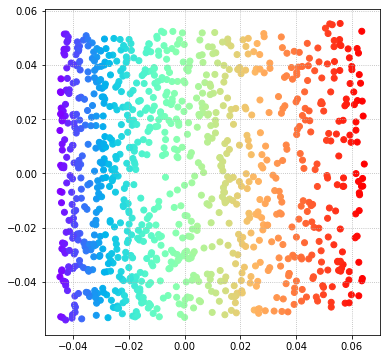

In [149]:
plt.figure(figsize=(6,6))
plt.grid(linestyle="dotted")
plt.scatter(X_ltsa[:, 0], X_ltsa[:, 1], c=color, cmap=plt.cm.rainbow)

### 2.8 Evaluating the performance

To evaluate the performance of manifold learning algorithms implement neighborhood preserving ratio (NPR) metric, which is defined as follows:

$$NPR = \frac{1}{kn} \sum_{i=1}^n \left|\mathcal{N}_k(x_i) \bigcap \mathcal{N}_k(z_i) \right|,$$

where $n$ is the number of data points, $\mathcal{N}_k(x_i)$ is the set of $k$-nearest neighbors of data points $x_i$ of original dimension and $\mathcal{N}_k(z_i)$ is the set of $k$-nearest neighbors of $z_i$ of reduced dimension. $|\cdot|$ represents the number of intersection points.

**Exercise:** Evaluate manifold learning methods performance using NPR as a metric on swiss roll for 3 different values of $k$.

In [165]:
def NPR(X, Z, k=21):
    
    _, neighborhood_X = NearestNeighbors(n_neighbors=k).fit(X).kneighbors(X)
    _, neighborhood_Z = NearestNeighbors(n_neighbors=k).fit(Z).kneighbors(Z)
    
    n = X.shape[0]
    npr = 0
    for i in range(n):
        npr += np.intersect1d(neighborhood_X[i], neighborhood_Z[i]).shape[0]
    
    return npr / (k * n)

In [166]:
NPR(X, X_kpca)

0.4053809523809524

In [170]:
data = [X_pca, X_kpca, X_isomap, X_lle, X_le, X_ltsa]

k = 25
n = X.shape[0]

for z in data:
    print(NPR(X, z, k))

0.612
0.40776
0.82812
0.69644
0.5446
0.61912


### 2.9. Digits

In [171]:
X, y = load_digits(return_X_y=True)
shape = (int(np.sqrt(X.shape[1])), int(np.sqrt(X.shape[1])))

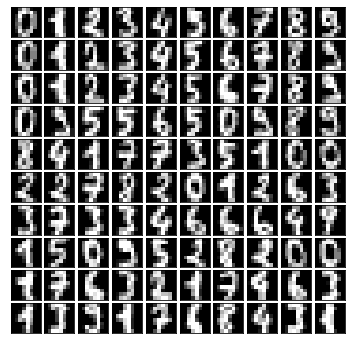

In [172]:
# plot numbers
_, ax = plt.subplots(10, 10, figsize=(6, 6),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, a in enumerate(ax.flat):
    a.imshow(X[i].reshape(shape), cmap=plt.cm.gray)

In [173]:
# n components, k nearest neighbors
n, k = 2, 15

models = [
    ("PCA", PCA(n_components=n)),
    ("Isomap", Isomap(n_components=n, n_neighbors=k)),
    ("LLE", LocallyLinearEmbedding(n_components=n, n_neighbors=k)),
    ("Laplacian Eignenmaps", SpectralEmbedding(n_components=n, n_neighbors=k))
]

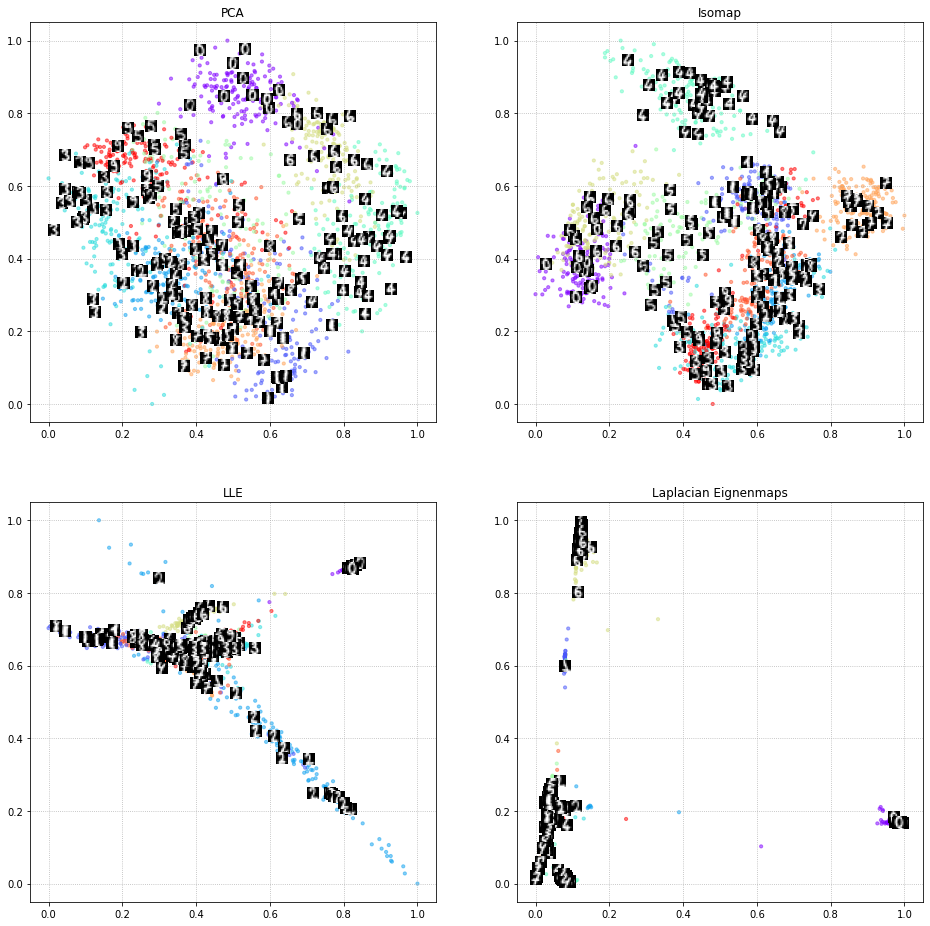

In [174]:
plt.figure(figsize=(16,25))

for key, model in enumerate(models):
    X_transformed = MinMaxScaler().fit_transform(model[1].fit_transform(X))
    plt.subplot(320 + (key+1))
    plt.title(model[0])
    plt.grid(linestyle="dotted")
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], alpha=0.5, s=10, c=y, cmap=plt.cm.rainbow)
    
    # plot images
    ax = plt.gca()
    for i in range(0, X.shape[0], 10):
        box = offsetbox.AnnotationBbox(offsetbox.OffsetImage(X[i].reshape(shape), cmap="gray", zoom=1.5), X_transformed[i], frameon=False)
        ax.add_artist(box)
    
plt.show()

### 2.10 MNIST

In [180]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
train_size = 60000

In [181]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [182]:
X_train, X_test, y_train, y_test = \
X[:train_size,:], X[train_size:,:], \
y[:train_size], y[train_size:]

print("Dataset summary:\nSamples: {}, features: {}, classes: {}"
      .format(X_train.shape[0] + X_test.shape[0], X_train.shape[1], np.unique(y_train).shape[0]))

Dataset summary:
Samples: 70000, features: 784, classes: 10


**Exercise:** explore manifolds of different digits, try to interpret embedding coordinates.

In [183]:
X = X_test[y_test.astype(int)==8]
shape = (int(np.sqrt(X.shape[1])), int(np.sqrt(X.shape[1])))

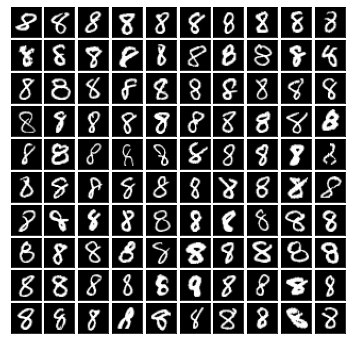

In [184]:
# plot numbers
_, ax = plt.subplots(10, 10, figsize=(6, 6),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, a in enumerate(ax.flat):
    a.imshow(X[i].reshape(shape), cmap=plt.cm.gray)

In [185]:
# n components, k nearest neighbors
n, k = 2, 15

models = [
    ("PCA", PCA(n_components=n)),
    ("Isomap", Isomap(n_components=n, n_neighbors=k)),
    ("LLE", LocallyLinearEmbedding(n_components=n, n_neighbors=k)),
    ("Laplacian Eignenmaps", SpectralEmbedding(n_components=n, n_neighbors=k))
]

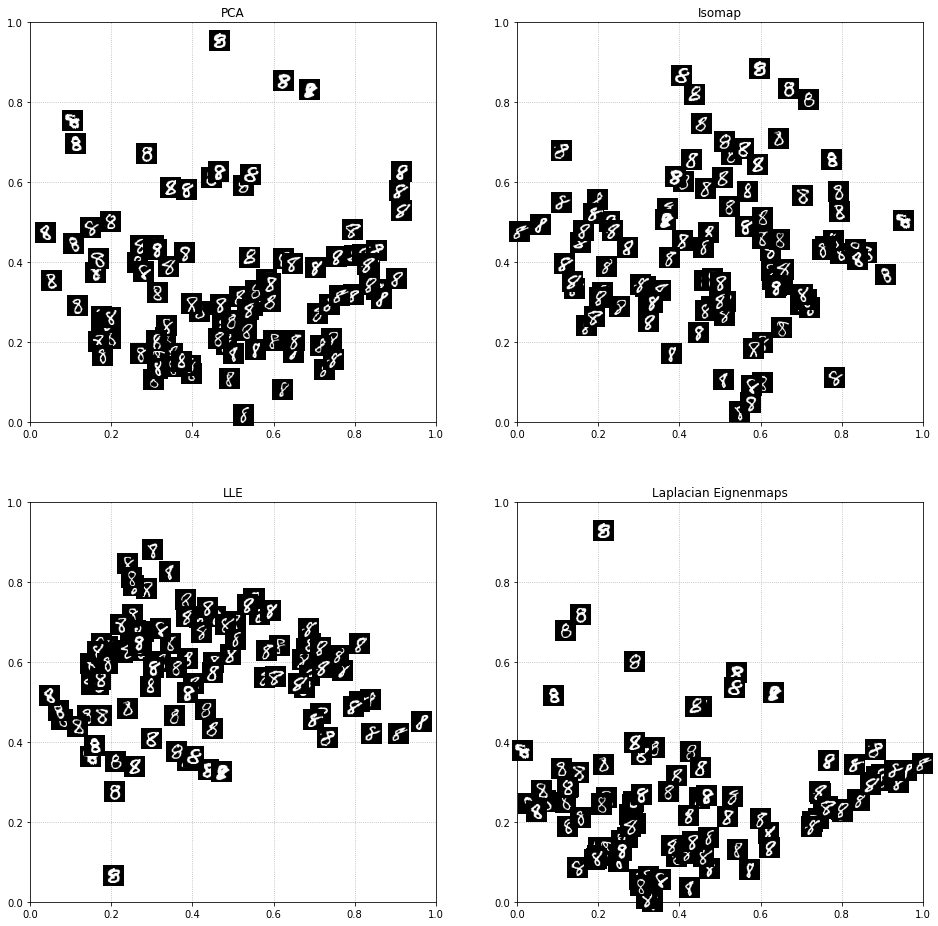

In [186]:
plt.figure(figsize=(16,25))

for key, model in enumerate(models):
    X_transformed = MinMaxScaler().fit_transform(model[1].fit_transform(X))
    plt.subplot(320 + (key+1))
    plt.title(model[0])
    plt.grid(linestyle="dotted")
    #plt.scatter(X_transformed[:, 0], X_transformed[:, 1], alpha=0.5, s=10)
    
    # plot images
    ax = plt.gca()
    for i in range(0, X.shape[0], 10):
        box = offsetbox.AnnotationBbox(offsetbox.OffsetImage(X[i].reshape(shape), cmap=plt.cm.get_cmap('gray'), zoom=0.75), X_transformed[i], frameon=False)
        ax.add_artist(box)
    
plt.show()

### 2.11 Airfoils

In [187]:
ref_points = np.loadtxt('../seminar1/data/ref_points.csv', delimiter=',')
X = np.loadtxt('../seminar1/data/airfoils.csv', delimiter=',')
X_oos = np.loadtxt('../seminar1/data/test_afl.csv', delimiter=',').reshape(1, -1)
X.shape, X_oos.shape

((199, 59), (1, 59))

In [188]:
# n components, k nearest neighbors
n, k = 2, 15

models = [
    ("PCA", PCA(n_components=n)),
    ("Isomap", Isomap(n_components=n, n_neighbors=k)),
    ("LLE", LocallyLinearEmbedding(n_components=n, n_neighbors=k)),
    ("Laplacian Eignenmaps", SpectralEmbedding(n_components=n, n_neighbors=k))
]

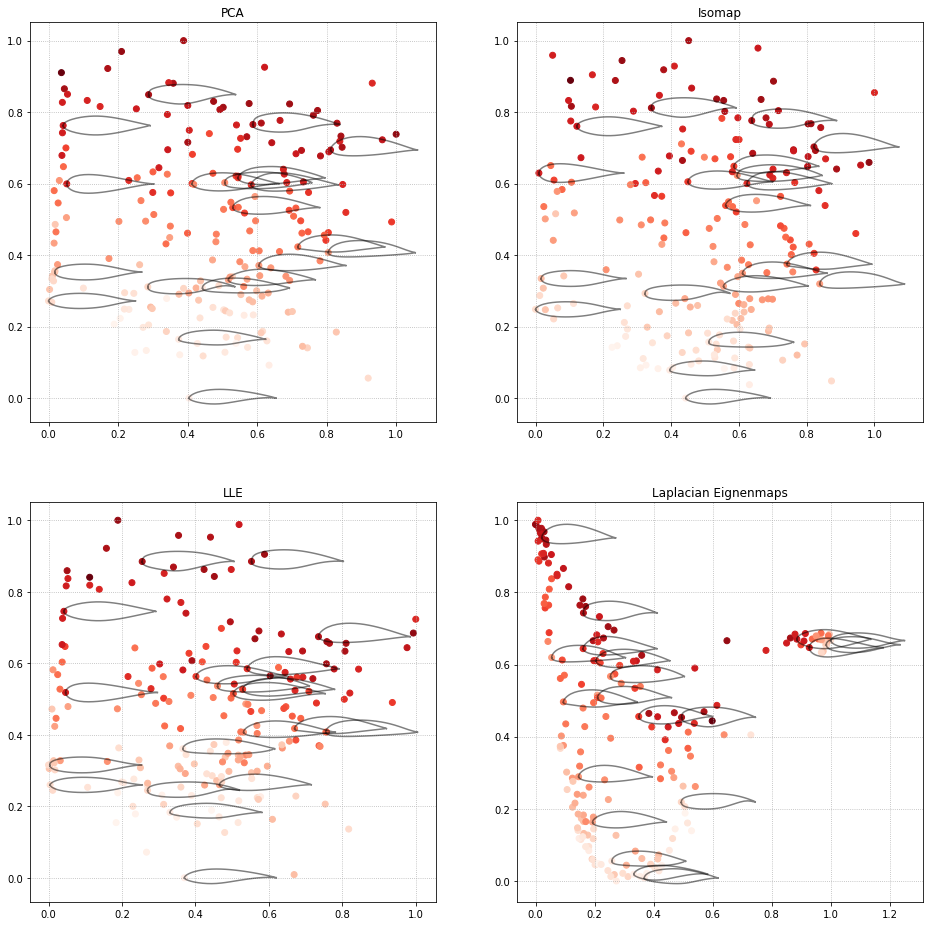

In [189]:
plt.figure(figsize=(16,25))

# color, proportional to height-to-width ratio
colors = MinMaxScaler().fit_transform((np.max(X[:, :], axis=1) - np.min(X[:, :], axis=1)).reshape(-1, 1)).ravel()

for key, value in enumerate(models):
    X_transformed = MinMaxScaler().fit_transform(value[1].fit_transform(X))
    plt.subplot(320 + (key+1))
    plt.title(value[0])
    plt.grid(linestyle="dotted")
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=colors, cmap="Reds")
    
    for i in range(0, 199, 10):
        plt.plot(X_transformed[i, 0] + ref_points / 4, X_transformed[i, 1] + X[i, :] / 2, '-', label = 'Airfoil #' + str(i), c='k', alpha=0.5)

plt.show()

## 3. Out-of-Sample extension

In [192]:
model = LocallyLinearEmbedding(n_components=2, n_neighbors=21).fit(X)

X_transformed = model.transform(X)
X_transformed_oos = model.transform(X_oos)

In [193]:
# scale data
scaler = MinMaxScaler().fit(X_transformed)
X_transformed = scaler.transform(X_transformed)
X_transformed_oos = scaler.transform(X_transformed_oos)

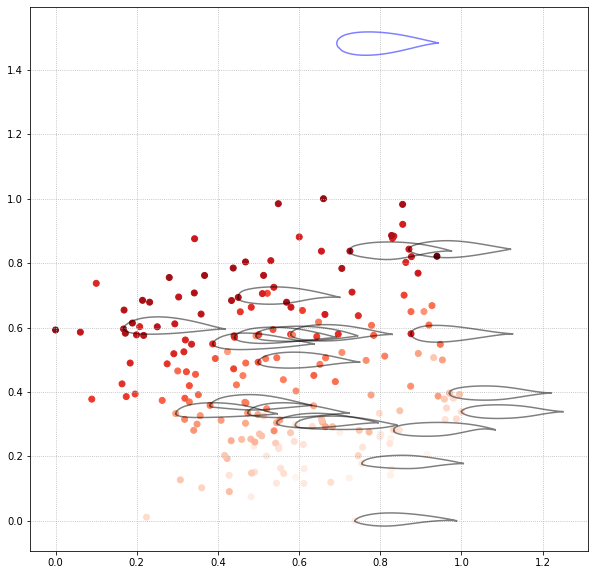

In [194]:
plt.figure(figsize=(10,10))
plt.grid(linestyle="dotted")
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=colors, cmap="Reds")
    
for i in range(0, 199, 10):
    plt.plot(X_transformed[i, 0] + ref_points / 4, X_transformed[i, 1] + X[i, :] / 2, '-', c='k', alpha=0.5)

plt.plot(X_transformed_oos[0, 0] + ref_points / 4, X_transformed_oos[0, 1] + X_oos[0, :] / 2, '-', c='b', alpha=0.5)

## 4. Non-Euclidean distances

In [195]:
take_n = 500

X = np.load("./data/lm_3000.npy")
X = X[:take_n]

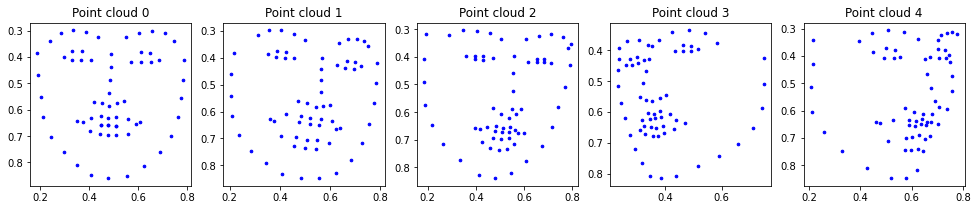

In [196]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16.75,3))
    
for i in range(5):
    ax[i].invert_yaxis()
    ax[i].set_title("Point cloud {}".format(i))
    ax[i].scatter(X[i,:,0], X[i,:,1], c="b", s=7)
        
plt.show()

### $p$-Wasserstein distance

Given 2 sets of vectors $\mathbf{a} \in \mathbb{R}^n$ and $\mathbf{b} \in \mathbb{R}^m$ (not nessesarily of same cardinality) the $p$-Wasserstein distance

\begin{equation}
    W_p^p := \min_{\mathbf{P} \in \mathbf{U}(\mathbf{a}, \mathbf{b})} \langle \mathbf{D}, \mathbf{P} \rangle_F,
\end{equation}

where $\mathbf{U}(\mathbf{a}, \mathbf{b}) := \{ \mathbf{P} \in \mathbb{R}^{n \times m}_{\geq 0} \mid \mathbf{P} \mathbf{1}_m = \mathbf{a}, \mathbf{P}^T \mathbf{1}_n = \mathbf{b} \}$, and $\mathbf{D}$ is matrix of $p$-th powers of the _ground distance_ between all pairs of vectors of $\mathbf{a}$ and $\mathbf{b}$. For $\mathbb{R}^n$ it is the Euclidean distance.

In [199]:
%%time
n, m, _ = X.shape
    
# distance matrix
D = np.zeros((n, n))

# uniform measures as points
a = np.ones(m) / m
b = np.ones(m) / m

for i in range(n):
    for j in range(i+1, n):

        # squared Euclidean distance as the ground metric
        M_ij = ot.dist(X[i], X[j], metric="sqeuclidean")

        # 2-Wasserstein distance, take square root
        D[i,j] = ot.emd2(a, b, M_ij) ** 0.5

D = D + D.T
D

CPU times: user 1min 18s, sys: 1.41 s, total: 1min 19s
Wall time: 1min 28s


array([[0.        , 0.04782941, 0.04937624, ..., 0.10395999, 0.03988998,
        0.0621283 ],
       [0.04782941, 0.        , 0.03511092, ..., 0.07620842, 0.05263317,
        0.08287807],
       [0.04937624, 0.03511092, 0.        , ..., 0.07804525, 0.05212704,
        0.08955   ],
       ...,
       [0.10395999, 0.07620842, 0.07804525, ..., 0.        , 0.09936696,
        0.14460181],
       [0.03988998, 0.05263317, 0.05212704, ..., 0.09936696, 0.        ,
        0.05925222],
       [0.0621283 , 0.08287807, 0.08955   , ..., 0.14460181, 0.05925222,
        0.        ]])

In [200]:
X_pc_mds = MDS(dissimilarity="precomputed", max_iter=1000, eps=1e-6, n_jobs=-1).fit_transform(D)
X_pc_le = Isomap(metric="precomputed", n_jobs=-1).fit_transform(D)

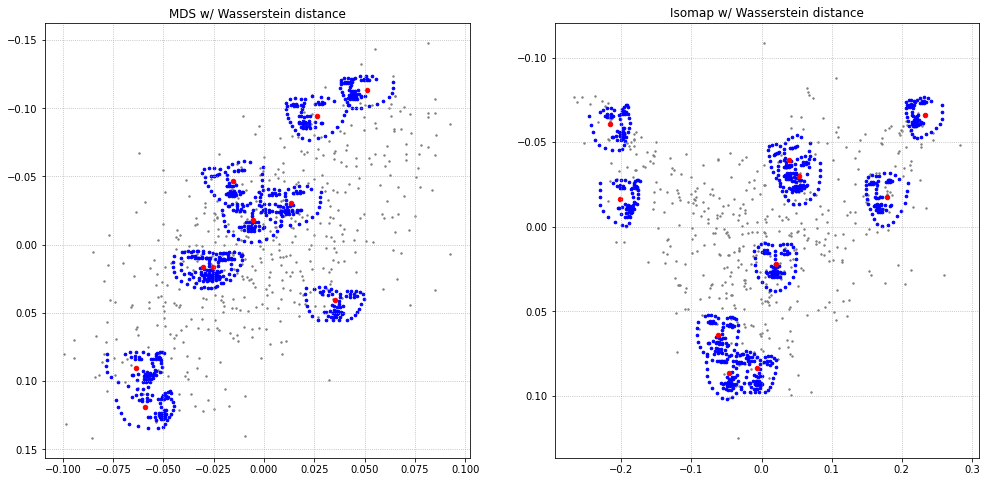

In [201]:
# for visualization purpose only
a_mds = np.array([0.05, 0.05])
a_isomap = np.array([0.1, 0.05])
b_mds = np.array([-0.025, -0.027])
b_isomap = np.array([-0.05, -0.027])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16.75,8))

ax[0].invert_yaxis()
ax[0].grid(linestyle="dotted")
ax[0].set_title("MDS w/ Wasserstein distance".format(i))
ax[0].scatter(X_pc_mds[:,0], X_pc_mds[:,1], c="grey", s=2)

for i in range(10):
    ax[0].scatter(X[i,:,0] * a_mds[0] + b_mds[0] + X_pc_mds[i,0], X[i,:,1] * a_mds[1] + b_mds[1] + X_pc_mds[i,1], s=7, c="b")
    ax[0].scatter(X_pc_mds[i,0], X_pc_mds[i,1], c="red", s=20)

ax[1].invert_yaxis()
ax[1].grid(linestyle="dotted")
ax[1].set_title("Isomap w/ Wasserstein distance".format(i))
ax[1].scatter(X_pc_le[:,0], X_pc_le[:,1], c="grey", s=2)

for i in range(10):
    ax[1].scatter(X[i,:,0] * a_isomap[0] + b_isomap[0] + X_pc_le[i,0], X[i,:,1] * a_isomap[1] + b_isomap[1] + X_pc_le[i,1], s=7, c="b")
    ax[1].scatter(X_pc_le[i,0], X_pc_le[i,1], c="red", s=20)
        
plt.show()